# GAN(Generative Adversarial Network)

https://github.com/nv-tlabs/GET3D

 수업이 힘듬 : 최소 몇 시간씩 모델을 만들어야 하기 때문에
 2014 년도 쯤에 나온 모델

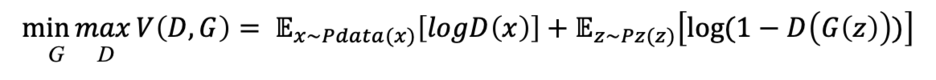


GAN - Celeb a data with colab



 참고자료

 - https://www.samsungsds.com/kr/insights/generative-adversarial-network-ai-2.html

- https://m.blog.naver.com/euleekwon/221557899873

- https://github.com/orpatashnik/StyleCLIP


In [ ]:
# celeb a data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/data/img_align_celeba.zip' -d '/content/drive/MyDrive/data/GAN/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197600.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197601.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197602.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197603.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197604.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197605.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197606.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197607.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197608.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197609.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197610.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/197611.jpg  
 extracting: /content/drive/MyDrive/data/GAN/img_align_celeba/19

33182


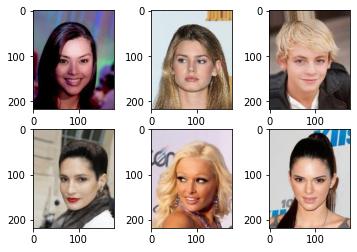

In [13]:
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image

imgs = glob.glob('/content/drive/MyDrive/data/GAN/img_align_celeba/*.jpg')

print(len(imgs))

for i in range(6):
    plt.subplot(2, 3, i+1)
    img = Image.open(imgs[i])
    plt.imshow(img)



In [14]:
# 입력 이미지 전처리
import torch
#import transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

In [15]:
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset = ImageFolder(
    root = '/content/drive/MyDrive/data/GAN/',
    transform = transforms
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)

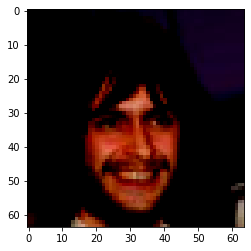

In [16]:
import numpy as np

iterdata = iter(loader)
img, label = iterdata.next()

img_test = img[3].numpy()
plt.imshow(np.transpose(img_test, (1,2,0)))

In [17]:
import torch.nn as nn

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100,512,kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512,256,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256,128,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128,64,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [24]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator,self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512,1,kernel_size=4),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

In [25]:
def weights_init(m):
    classname = type(m).__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weights.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [26]:
import tqdm
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5,0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5,0.999))


In [ ]:
for epochs in range(20):
    iterator = tqdm.tqdm(enumerate(loader,0), total=len(loader))

    for i,data in iterator:
        D_optim.zero_grad()

        label = torch.ones_like(data[1], dtype=torch.float32 ).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

        #진짜 이미지를 1로 판별
        real = D(data[0].to(device))
        #128,1,1,1
        Dloss_real = nn.BCELoss()(torch.squeeze(real),label)
        Dloss_real.backward()

        noise = torch.randn(label.shape[0], 100, 1,1, device=device)

        fake = G(noise)

        output = D(fake.detach())

        Dloss_fake = nn.BCELoss()(torch.squeeze(output),label_fake)
        Dloss_fake.backward()

        Dloss = Dloss_real + Dloss_fake
        D_optim.step()

        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output),label)
        Gloss.backward()

        G_optim.step()

        iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

    torch.save(G.state_dict(), "Generator.pth")
    torch.save(D.state_dict(), "Discriminator.pth")

epoch:0 iteration:66 D_loss:0.05541497468948364 G_loss:7.258909702301025:  26%|██▌       | 67/260 [1:34:27<4:29:09, 83.68s/it]